## Training the HEIP nuclei segmentation model

This notebook shows how to train the HEIP segmentation model with the full [Pannuke dataset](https://arxiv.org/abs/2003.10778) extended with HGSOC annotations from Helsinki University. The training data and validation data is available as a .hdf5 file at [here](http://google.com). The file contains (img, instance mask, type mask) tuples of size 256x256. The HU images and mask .mat files can be obtained from the same place. (LET'S PUT THE .h5 and the in-house images/annotations to a drive or dropbox!!)

In [1]:
# from cellseg_models_pytorch.datamodules import SimpleDownloader
# from pathlib import Path

# url = Path("https://url/to/hdf5/")
# save_dir = Path("/path/to/save_dir")
# # gdrive_id = "google_drive_id" # file_id can be obtained from from a sharable link.

# # use either download or the google drive download method.
# SimpleDownloader.download(url, save_dir=save_dir)
# # SimpleDownloader.gdrive_download(gdrive_id, file_name="heip_data.zip", save_dir=save_dir) 

## Visualize training and validation patches

Here we will define the torch datasets that read data from the HDF5 file and. Then we'll look at some patches of the validation HGSOC image, mask pairs. 

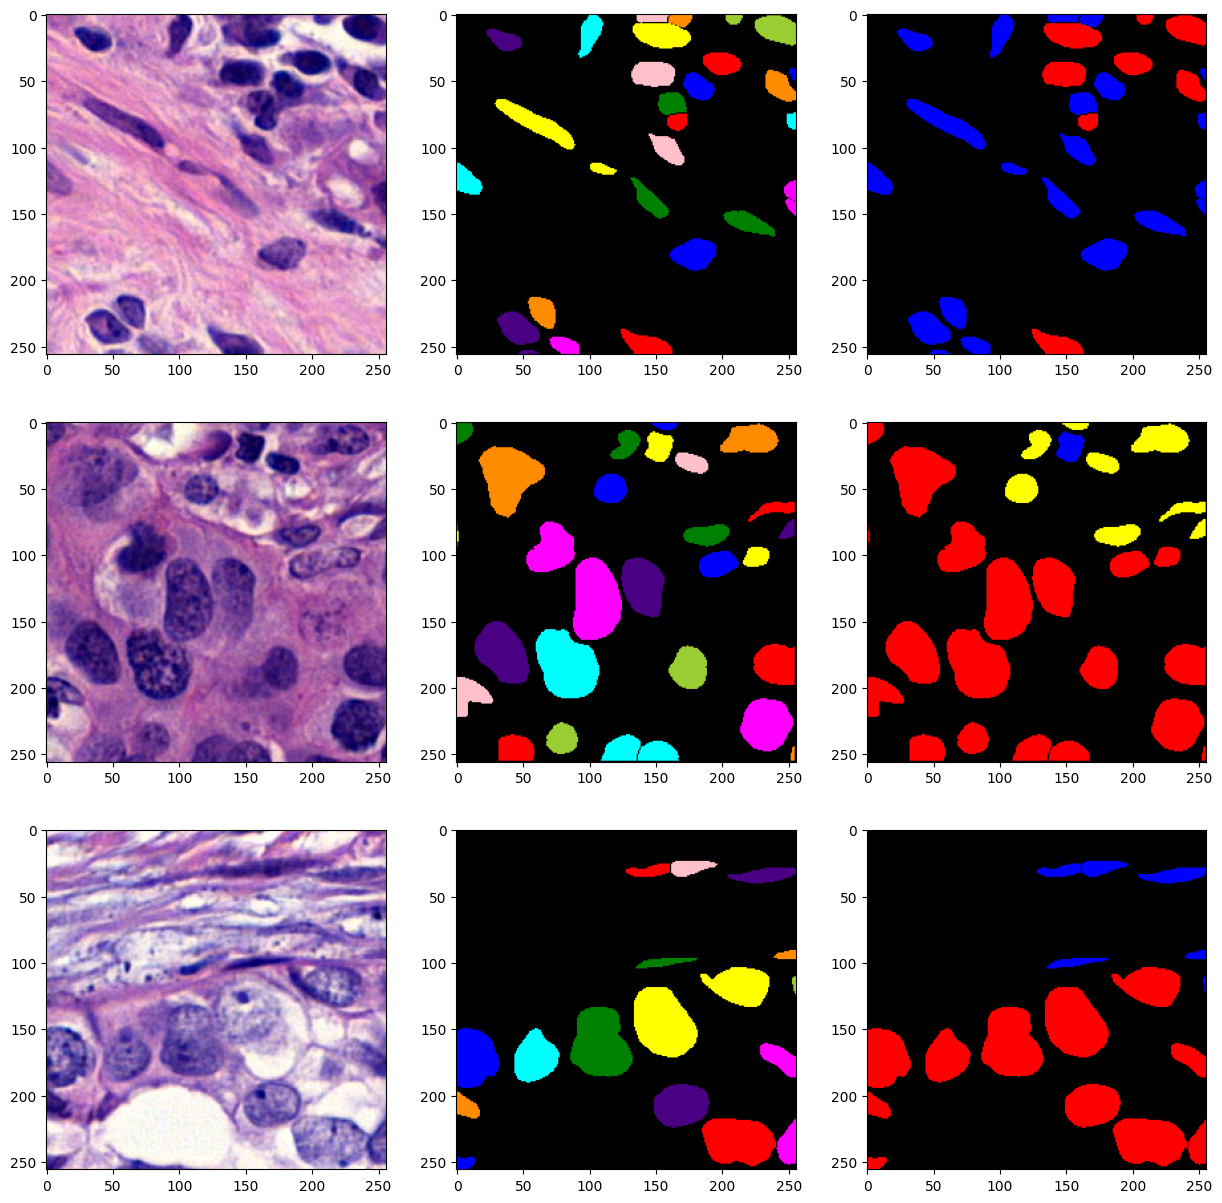

In [2]:
import matplotlib.pyplot as plt
from skimage.color import label2rgb
from pathlib import Path
from cellseg_models_pytorch.datasets.hdf5_dataset import SegmentationHDF5Dataset

save_dir = Path("/path/to/hdf5data.h5") # MODIFY THIS TO MATCH WHERE YOU SAVED THE .h5 FILE

train_data = SegmentationHDF5Dataset(
    save_dir / "pannuke_ovca.h5",
    img_transforms=["hue_sat", "blur"],
    inst_transforms=["omnipose"],
    normalization="minmax",
    return_binary=True,
    return_inst=False,
)

valid_data = SegmentationHDF5Dataset(
    save_dir / "ovca_valid.h5",
    img_transforms=[],
    inst_transforms=["omnipose"],
    normalization="minmax",
    return_binary=True,
    return_inst=False,
)

patch1 = valid_data.read_h5_patch(5)
patch2 = valid_data.read_h5_patch(100)
patch3 = valid_data.read_h5_patch(500)

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax = ax.flatten()
ax[0].imshow(patch1["image"])
ax[1].imshow(label2rgb(patch1["inst"], bg_label=0))
ax[2].imshow(label2rgb(patch1["type"], bg_label=0))
ax[3].imshow(patch2["image"])
ax[4].imshow(label2rgb(patch2["inst"], bg_label=0))
ax[5].imshow(label2rgb(patch2["type"], bg_label=0))
ax[6].imshow(patch3["image"])
ax[7].imshow(label2rgb(patch3["inst"], bg_label=0))
ax[8].imshow(label2rgb(patch3["type"], bg_label=0))

# Training the model

For the sake of demonstration (and this laptop's GPU memory limits) we will set a smaller encoder and less depth than in the manuscript. Specifically, we will use the EfficientNetV2-s variant as the encoder with depth of 4.

In [3]:
from src.unet import get_seg_model

unet = get_seg_model(depth=4, encoder="tf_efficientnetv2_s")

**Next we will train the model using [`cellseg_models.pytorch`](https://github.com/okunator/cellseg_models.pytorch) training utiilities and [pytorch lightning](https://pytorch-lightning.readthedocs.io/en/latest/)**.

Training info:

- For every output branch of the network we will set a distinct loss function.
    - omnipose branch is optimized with `mse_ssim` joint loss
    - nuclei type segmentation branch is optimized with `tversky_focal` joint loss
    - foregrond/background segmentation branch is optimized with `tversky_focal` joint loss
    - for the segmentation branches, we will use **label smoothing** for regularization.
    - We will also use **weight decay** for regularization.
    - We will set a small learning rate for the encoder and 10x bigger for the newly initialized decoders
- For every branch output we will be logging distinct performance metrics
    - for omnipose output, the `mse` metric is followed
    - for nuclei type output, the `miou` metric is followed
    - for nuclei output, the `miou` metric is followed
- We will use the **AdamW** optimizer for training
- **Since our training data is quite large, we will finetune for only 1 epoch just for the sake of demoing.**

In [4]:
from cellseg_models_pytorch.training.lit import SegmentationExperiment
import pytorch_lightning as pl

# Set branch losses
branch_losses = {
    "omnipose": "ssim_mse",
    "type": "tversky_focal",
    "inst": "tversky_focal"
}

# Set label smoothing
branch_loss_params = {
    "inst": {"apply_ls": True},
    "type": {"apply_ls": True},
    "omnipose": {"k": None}
}

# Set branch metrics
branch_metrics = {
    "omnipose": ["mse"],
    "type": ["miou"],
    "inst": ["miou"]
}

optim_params = {
    "encoder": {"lr": 0.00005, "weight_decay": 0.00003},
    "decoder": {"lr": 0.0005, "weight_decay": 0.0003},
}

# We will be monitoring for the mIoU score of the type maps.
# for each output, we will define separate joint-losses.
experiment = SegmentationExperiment(
    model=unet,
    branch_losses=branch_losses,
    branch_loss_params=branch_loss_params,
    branch_metrics=branch_metrics,
    optimizer="adamw",
)

# Lightning training, train
trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=1,
    move_metrics_to_cpu=True,
)

/home/leos/.conda/envs/HEIP/lib/python3.10/site-packages/cellseg_models_pytorch/optimizers/__init__.py:61: UserWarning: `torch_optimizer` optimzers not available. To use them, install with `pip install torch-optimizer`.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
from cellseg_models_pytorch.datamodules.custom_datamodule import CustomDataModule

# Set up a custom lightning datamodule from our datasets. Since we are not
# going to do any testing, we will just set the test set to None
datamodule = CustomDataModule(
    [train_data, valid_data, None],
    batch_size=4,
    num_workers=4,
)

# Train the model
trainer.fit(model=experiment, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | model         | MultiTaskUnet | 25.6 M
1 | criterion     | MultiTaskLoss | 0     
2 | train_metrics | ModuleDict    | 0     
3 | val_metrics   | ModuleDict    | 0     
4 | test_metrics  | ModuleDict    | 0     
------------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.332   Total estimated model params size (MB)


Epoch 0: 100%|██████████| 15107/15107 [1:36:58<00:00,  2.60it/s, loss=0.742, v_num=2, train_loss=0.781, train_omnipose_mse=0.0332, train_type_miou=0.708, train_inst_miou=0.832] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 15107/15107 [1:36:59<00:00,  2.60it/s, loss=0.742, v_num=2, train_loss=0.781, train_omnipose_mse=0.0332, train_type_miou=0.708, train_inst_miou=0.832]


# Inference

We will now run inference for one image in our validation set to see whether the model learned anything.

In [6]:
from cellseg_models_pytorch.inference import SlidingWindowInferer

in_dir = "/path/to/valid/images" # MODIFY THIS TO MATCH WHERE YOUR VALIDATION IMG ARE SAVED

inferer = SlidingWindowInferer(
    model=experiment,
    input_folder=in_dir,
    out_activations={"omnipose": "tanh", "type": "softmax", "inst": "softmax"},
    out_boundary_weights={"omnipose": True, "type": False, "inst": False},
    padding=80,
    stride=128,
    patch_size=(256, 256),
    instance_postproc="omnipose",
    normalization="minmax", # same normalization as during training
    batch_size=1, # We need to load only 1 image to mem
    n_images=1, # Use only the 3 first images of the folder
)
inferer.infer()

Running inference: 100%|██████████| 1/1 [00:12<00:00, 12.82s/batch, post-processing]


# Visualize one result

From the result segmentation below, we already see that by training for only one epoch the model learns to predict surprisingly well by just eyeballing the result.

The classes that are predicted
- red - neoplastic cells
- green - inflammatory cells
- yellow - stromal cells

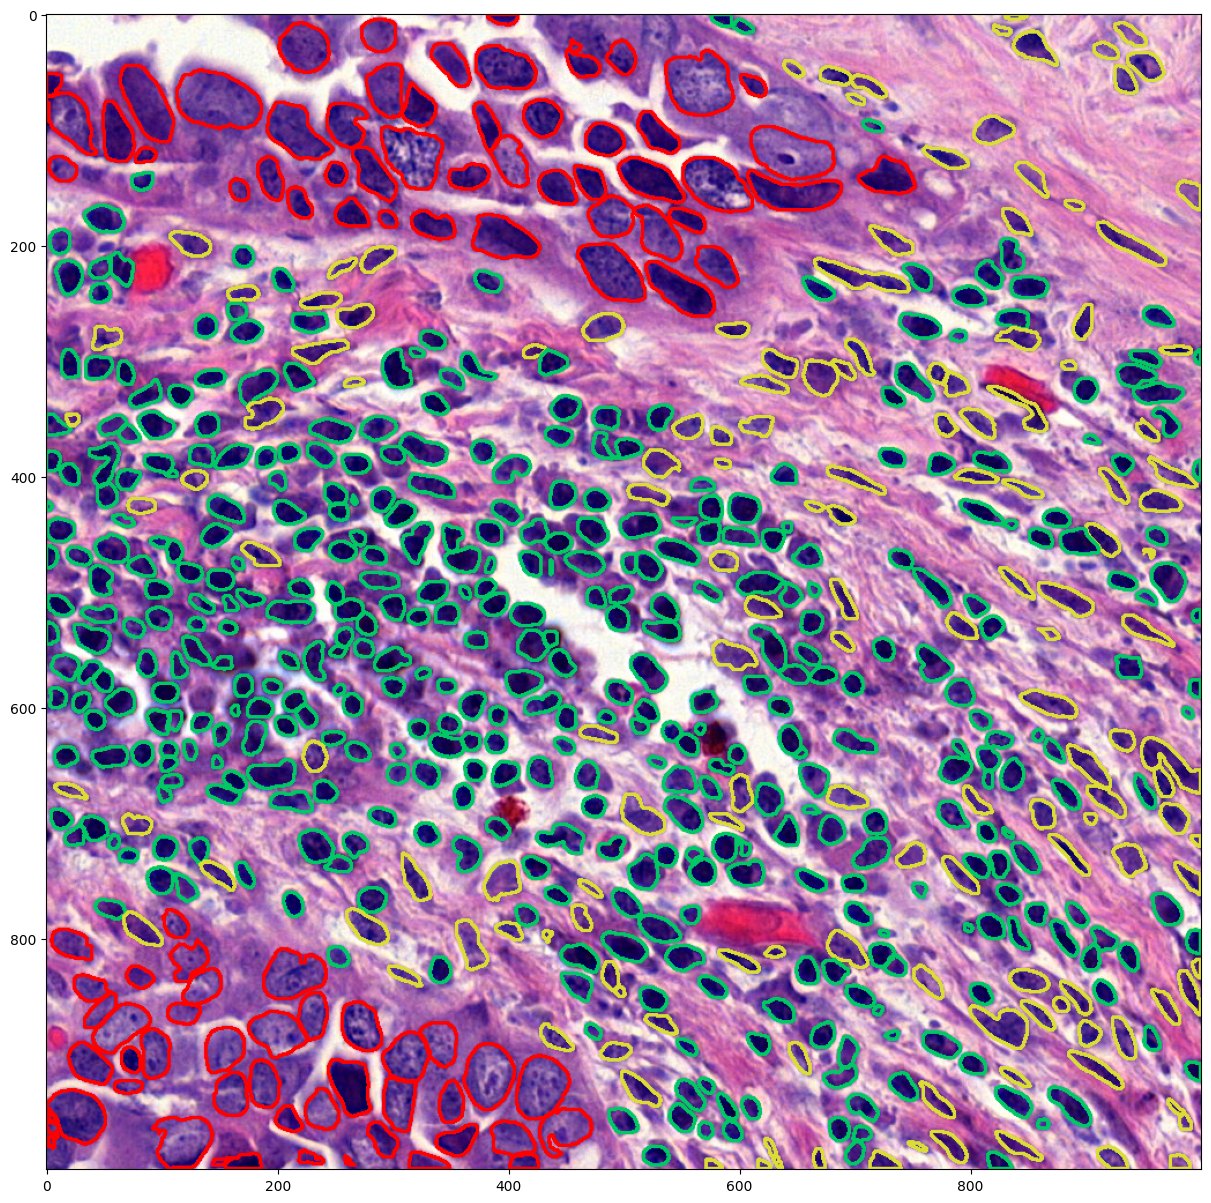

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from cellseg_models_pytorch.utils import FileHandler, draw_thing_contours

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

samples = list(inferer.out_masks.keys())
masks = inferer.out_masks[samples[0]]

img_path = Path(in_dir) / f"{samples[0]}.png"
img = FileHandler.read_img(img_path)
cont = draw_thing_contours(masks["inst"], img, masks["type"])
ax.imshow(cont)